DRQN Cartpole-v1 environment

- Bootstrapped Squential Updates
- Using GRU (not LSTM)

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np
import time
import random

In [2]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(4,64)
        self.fc_gru = nn.GRU(64,32)
        self.fc_q = nn.Linear(32,2)
        self.optimizer = optim.Adam(self.parameters(), lr=0.0003)
    
    def Q(self, x, h_in):
        x = F.relu(self.fc1(x))
        x = x.reshape(-1,1,64)
        x, h_out = self.fc_gru(x, h_in)
        x = x.reshape(-1,32)
        q = self.fc_q(x)
        return q, h_out
    
    def train(self, loss):
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

In [3]:
env = gym.make('CartPole-v1')
model = DQN()
GAMMA = 0.98
EPSILON = 0.1
N = 500 ## reply memory size

In [4]:
def epsilon_greedy(Q, eps, action_dim):
    if random.random() < eps:
        action = random.randint(0, action_dim-1)
    else:
        action = torch.argmax(Q[0]).item()
    return action

class Replay_memory():
    def __init__(self):
        self.replay_mem = []
        self.episode_mem = []
        
    def store_transition(self, state, action, reward, next_state, done, h_in, h_out):
        s = state.unsqueeze(0)
        s_p = next_state.unsqueeze(0)
        a = torch.tensor([[action]])
        r = torch.tensor([[reward]])
        h_i = h_in
        h_o = h_out
        if done:
            d = torch.tensor([[0]], dtype=torch.float)
        else:
            d = torch.tensor([[1]], dtype=torch.float)
        self.episode_mem.append((s,a,r,s_p,d,h_i.detach(),h_o.detach()))
        
        if done:
            if len(self.replay_mem) == N: del(self.replay_mem[0])
            self.replay_mem.append(self.episode_mem)
            self.episode_mem = []
            
    def make_episode_batch(self):
        ep_batch = random.sample(self.replay_mem, 1)
        s_list, a_list, r_list, s_p_list, h_in_list, h_out_list, done_list  = [], [], [], [], [], [], []
        for transition in ep_batch[0]:
            s, a, r, s_p, d, h_i, h_o = transition
            s_list.append(s)
            a_list.append(a)
            r_list.append(r)
            s_p_list.append(s_p)
            h_in_list.append(h_i)
            h_out_list.append(h_o)
            done_list.append(d)
        return torch.cat(s_list, dim=0), torch.cat(a_list, dim=0), torch.cat(r_list, dim=0), torch.cat(s_p_list, dim=0),\
                torch.cat(done_list, dim=0), h_in_list[0], h_out_list[0]
    
    def mem_size(self):
        return len(self.replay_mem)
    
def training(replay_mem):
    s, a, r, s_p, done_mask, h_in, h_out = replay_mem.make_episode_batch()
    
    cur_Q = model.Q(s, h_in)[0]
    next_Q = model.Q(s_p, h_out)[0]
    td_target = r + GAMMA*torch.max(next_Q, dim=1)[0].reshape(-1,1)*done_mask
    loss = (td_target.detach() - cur_Q.gather(1,a)).pow(2).mean()
    model.train(loss)
    
def test_agent():
    reward_sum = 0.0
    for ep in range(10):
        observation = env.reset()
        h_out = torch.zeros([1, 1, 32], dtype=torch.float)
        while True:
            state = torch.tensor(observation, dtype=torch.float)
            h_in = h_out
            action = torch.argmax(model.Q(state, h_in)[0])
            observation, reward, done, _ = env.step(action.item())
            reward_sum += reward
            if done: break
    return reward_sum/10.0

In [5]:
replay_memory = Replay_memory()
reward_list = []

for ep in range(20000):
    observation = env.reset()
    h_out = torch.zeros([1, 1, 32], dtype=torch.float)
    while True:
        state = torch.tensor(observation, dtype=torch.float)
        h_in = h_out
        Q, h_out = model.Q(state, h_in)
        action = epsilon_greedy(Q, EPSILON, 2)
        observation, reward, done, _ = env.step(action)
        next_state = torch.tensor(observation, dtype=torch.float)
        replay_memory.store_transition(state, action, reward, next_state, done, h_in, h_out)
        if replay_memory.mem_size() > 10:
            training(replay_memory)
        if done:
            break
            
    if ep % 20 == 19:
        test_reward = test_agent()
        print('Episode %d'%ep,', Greedy action reward : %f'%(test_reward))
        reward_list.append(test_reward)
        if test_reward > 470: break
        
env.close()

Episode 19 , Greedy action reward : 9.200000
Episode 39 , Greedy action reward : 9.200000
Episode 59 , Greedy action reward : 9.200000
Episode 79 , Greedy action reward : 9.400000
Episode 99 , Greedy action reward : 9.100000
Episode 119 , Greedy action reward : 9.300000
Episode 139 , Greedy action reward : 10.700000
Episode 159 , Greedy action reward : 11.600000
Episode 179 , Greedy action reward : 13.000000
Episode 199 , Greedy action reward : 13.900000
Episode 219 , Greedy action reward : 15.400000
Episode 239 , Greedy action reward : 19.000000
Episode 259 , Greedy action reward : 22.200000
Episode 279 , Greedy action reward : 44.500000
Episode 299 , Greedy action reward : 9.500000
Episode 319 , Greedy action reward : 107.000000
Episode 339 , Greedy action reward : 130.900000
Episode 359 , Greedy action reward : 149.300000
Episode 379 , Greedy action reward : 500.000000


Learning curve

10 game mean score every 20 episode

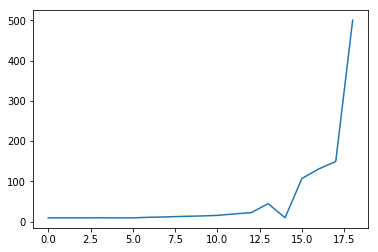

In [6]:
plt.plot(reward_list)
plt.show()